In [79]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [80]:
import tensorflow as tf
import datetime

In [81]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28), name='layers_flatten'),
    tf.keras.layers.Dense(512, activation='relu', name='layers_dense'),
    tf.keras.layers.Dropout(0.2, name='layers_dropout'),
    tf.keras.layers.Dense(10, activation='softmax', name='layers_dense_2')
  ])

In [82]:
import os

In [83]:
os.curdir

'.'

In [84]:
model = create_model()

In [85]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir(): 
    import time 
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") 
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_logdir, histogram_freq=1)

In [86]:
run_logdir

'.\\my_logs\\run_2023_07_25-12_34_22'

In [87]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [88]:
%%capture

history = model.fit(x=x_train,
                    y=y_train,
                    epochs=30,
                    validation_data=(x_test, y_test),
                    callbacks=[tensorboard_callback])

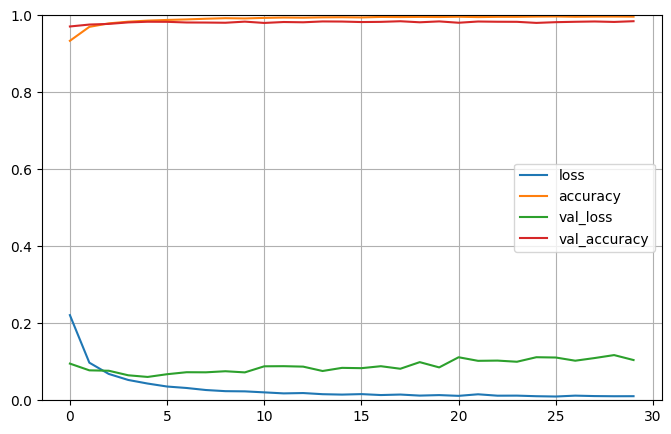

In [89]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [90]:
%tensorboard --logdir=.\\my_logs

Reusing TensorBoard on port 6006 (pid 20252), started 1 day, 22:37:27 ago. (Use '!kill 20252' to kill it.)

In [91]:
from tensorflow import keras

In [92]:
from sklearn.datasets import fetch_california_housing 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

In [93]:
housing = fetch_california_housing()

In [94]:
X_train_full, X_test, y_train_full, y_test = train_test_split( housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full)

In [95]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) 
X_valid_scaled = scaler.transform(X_valid) 
X_test_scaled = scaler.transform(X_test)

In [96]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model
    

In [97]:
#%pip install scikeras[tensorflow]

In [98]:
import scikeras
from scikeras.wrappers import KerasRegressor
from keras.callbacks import History

In [99]:
keras_reg =  KerasRegressor(build_model)

In [100]:
history = keras_reg.fit(X_train_scaled, y_train, epochs=100,
                        validation_data=(X_valid_scaled, y_valid),
                        callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test_scaled, y_test)
y_pred = keras_reg.predict(X_test[:3])

Epoch 1/100


363/363 [==============================] - 1s 1ms/step - loss: 1.1871 - val_loss: 16.7985
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 1.4891 - val_loss: 1.7354
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.6218 - val_loss: 0.5541
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5089 - val_loss: 0.4980
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4714 - val_loss: 0.4687
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4492 - val_loss: 0.4520
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4344 - val_loss: 0.4405
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4253 - val_loss: 0.4378
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4163 - val_loss: 0.4230
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4098 - val_loss: 0.4183


In [101]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

In [102]:
import numpy as np

In [103]:
def build_model(n_hidden, n_neurons, meta):
    model = keras.models.Sequential()
    # note that I added the meta parameter, you can access all of the SciKeras attributes
    # https://scikeras.readthedocs.io/en/latest/generated/scikeras.wrappers.KerasRegressor.html
    n_features_in_ = meta["n_features_in_"]
    model.add(keras.layers.InputLayer(input_shape=(n_features_in_, )))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    return model  # note that I return an un-compiled model here, SciKeras will compile it for you!


keras_reg = scikeras.wrappers.KerasRegressor(
    build_model,
    n_neurons=30,
    n_hidden=1,
    optimizer__lr=3e-3,  # just specify parameters here, you won't have to edit build_model to add/remove things you're tuning
    optimizer=keras.optimizers.SGD,  # note that I am giving SciKeras a class, not an instance
   loss="mse",
)
    

param_distribs = {
    "n_hidden" : [0, 1, 2, 3],
    "n_neurons" : np.arange(1, 100, 10),
    "optimizer__lr" : np.arange(3e-4, 3e-2, 0.3*(1e-2 - 1e-4))
}

In [104]:
np.arange(1, 100)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

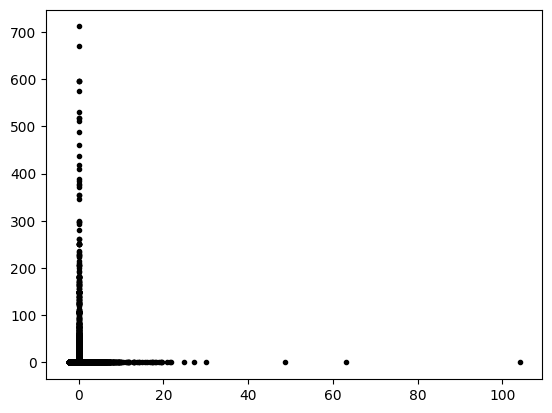

In [105]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

rv = reciprocal(3e-4, 3e-2)
ax.plot(X_train_scaled, rv.pdf(X_train_scaled), 'k.', lw=2, label='frozen pdf')

In [106]:
%%capture
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [107]:
rnd_search_cv.best_params_

{'optimizer__lr': 0.0003, 'n_neurons': 91, 'n_hidden': 3}

In [108]:
rnd_search_cv.best_score_

0.7854984795651837

In [109]:
model = rnd_search_cv.best_estimator_.model